## Introduction

The Coastal Marine Zones dataset used in this notebook can be found here.

Abstract:

Coastal marine forecasts and Special Marine Warnings are issued by zone, each zone identified by a text description and a Universal Generic Code (UGC). These forecasts are prepared by the individual Weather Forecast Office responsible for the zone.

Purpose:

To deliniate the coastal marine zones for the use in creating coastal marine forecasts and warnings.


https://www.weather.gov/gis/MarineZones

In [1]:
import os.path, json, io
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (32, 40)

import pyspark.sql.functions as func # resuse as func.coalace for example
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType
from pyspark.sql import SparkSession

import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
from ast import literal_eval as make_tuple # used to decode data from java

In [2]:
# Create SparkSession and attach Sparkcontext to it
spark = SparkSession.builder.appName("coastal-marine-zones").getOrCreate()
sc = spark.sparkContext

## Task1 : Load Coastal Marine ZonesData

In [3]:
# Load the boundaries data
mz_df = GeoDataFrame.from_file('/home/tri/Spark/dataset/mz05de17/')

In [4]:
mz_df.columns

Index([u'ID', u'WFO', u'GL_WFO', u'NAME', u'LON', u'LAT', u'geometry'], dtype='object')

In [5]:
mz_df.head()

,ID,WFO,GL_WFO,NAME,LON,LAT,geometry
0,PHZ113,HFO,None,Kauai Channel,-158.972420,21.616939,"POLYGON ((-158.745995314 22.08591056400007, -1..."
1,PHZ112,HFO,None,Kauai Leeward Waters,-160.231390,21.664122,"POLYGON ((-159.62633932 22.19913730500002, -15..."
2,GMZ155,BRO,None,Coastal waters from Baffin Bay to Port Mansfie...,-97.157908,26.906845,POLYGON ((-96.88227653499996 26.59007835400007...
3,GMZ657,MFL,None,Coastal waters from East Cape Sable to Chokolo...,-81.389492,25.453694,POLYGON ((-81.34737199999995 25.82093900000007...
4,GMZ656,MFL,None,Coastal waters from Chokoloskee to Bonita Beac...,-81.872501,25.953719,(POLYGON ((-81.35332512199994 25.8227071780000...


Detailed Description of the columns:
- ID: Identifier of zone
- WFO: Identifier of organization responsible for forecast to the zone
- NAME: Name of zone
- LON: Longitude of centroid zone
- LAT: Latitude of centroid of zone

In [6]:
mz_df.crs

{'init': u'epsg:4269'}

## Task 2: Load Offshore Marine Zones data

In [7]:
oz_df = GeoDataFrame.from_file('/home/tri/Spark/dataset/oz01ap14/')


In [8]:
oz_df.head()

,ID,WFO,LON,LAT,LOCATION,NAME,geometry
0,AMZ031,NH2,-79.34953,11.83763,from 11N-15N between 72W-80W,Caribbean from 11N to 15N between 72W and 80W ...,POLYGON ((-72.00606649499997 15.03032157200005...
1,AMZ013,NH2,-81.74130,18.75795,north of 18N between 76W-85W,Caribbean N of 18N between 76W and 85W includi...,POLYGON ((-82.34419558999997 22.48400648500007...
2,AMZ037,NH2,-59.99007,14.44086,from 7N-15N between 55W-60W,Tropical N Atlantic from 7N and 15N between 55...,POLYGON ((-54.98014895199998 15.00294936700004...
3,AMZ121,NH2,-72.99113,24.81218,from 22N-27N between 65W-70W,Atlantic from 22N to 27N between 65W and 70W,POLYGON ((-64.99909230599997 22.00331475900003...
4,AMZ011,NH2,-81.74130,18.75795,from 18N-22N west of 85W to Yucatan Peninsula ...,Caribbean Nof 18N W of 85W including Yucatan B...,POLYGON ((-85.00351240299995 21.65418662700006...


In [9]:
oz_df.crs

{'init': u'epsg:4269'}

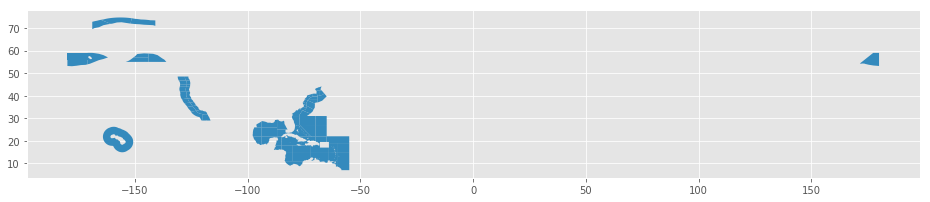

In [10]:
oz_df.plot(figsize=(16, 8))
plt.show()

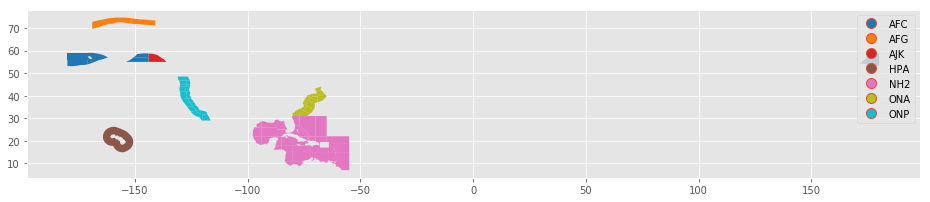

In [11]:
oz_df.plot(column='WFO', categorical=True, legend=True, figsize=(16, 8))
plt.show()

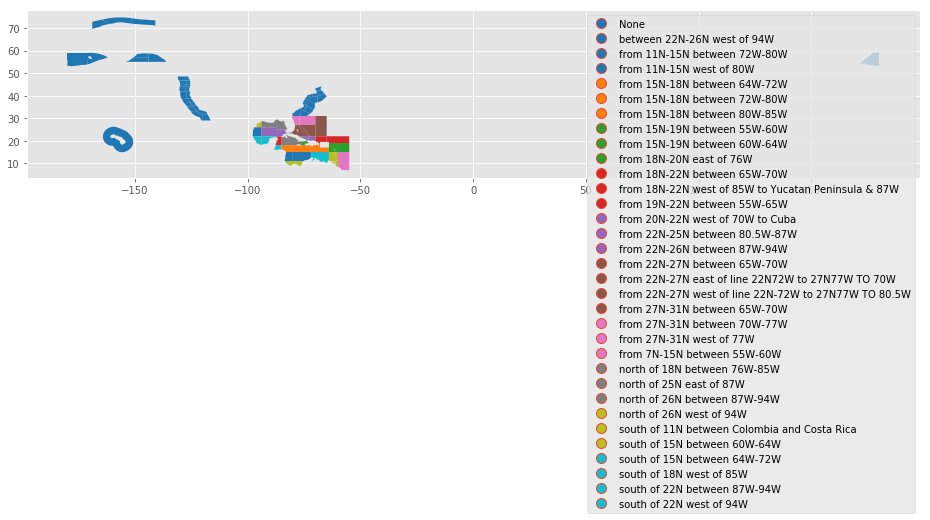

In [12]:
oz_df.plot(column='LOCATION', categorical=True, legend=True, figsize=(16, 8))
plt.show()

## Task 3: Load High Seas Marine Zones data

In [13]:
hz_df = GeoDataFrame.from_file('/home/tri/Spark/dataset/hz04jn14/')

In [14]:
hz_df.head()

,WFO,NAME,LAT,LON,id,geometry
0,OPC,North Atlantic Ocean between 31N and 67N latit...,48.95213,-44.40468,None,(POLYGON ((-81.51807499966134 31.0045729997444...
1,NHC,Atlantic Ocean West of 35W longitude between 3...,18.96140,-66.43170,None,(POLYGON ((-80.76558399960174 25.1674449997871...
2,NHC,Eastern South Pacific Ocean between 3.4S and ...,-9.13155,-95.25638,None,(POLYGON ((-70.40097017504525 -18.349999999999...
3,HPA,Central South Pacific Ocean between the Equato...,-12.71287,-149.99985,None,(POLYGON ((-139.9999999999999 0.00026303200030...
4,NHC,Eastern North Pacific Ocean between the Equato...,15.00008,-108.51445,None,POLYGON ((-114.9738617859924 31.92294689918015...


In [15]:
hz_df.crs

{'init': u'epsg:4269'}

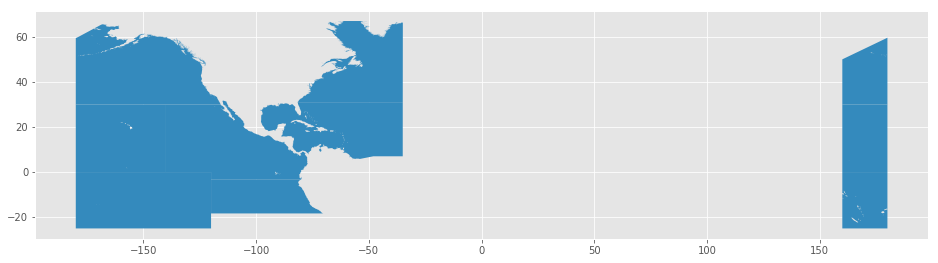

In [16]:
hz_df.plot(figsize=(16,8))
plt.show()


## Task 4: Load "Natural Earth" countries dataset, bundled with GeoPandas

"Natural Earth is a public domain map dataset available at 1:10m, 1:50m, and 1:110 million scales. Featuring tightly integrated vector and raster data, with Natural Earth you can make a variety of visually pleasing, well-crafted maps with cartography or GIS software." It (a subset?) comes bundled with GeoPandas and is accessible from the gpd.datasets module. We'll use it as a helpful global base layer map.


In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head(2)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...


In [18]:
world.crs

{'init': u'epsg:4326'}

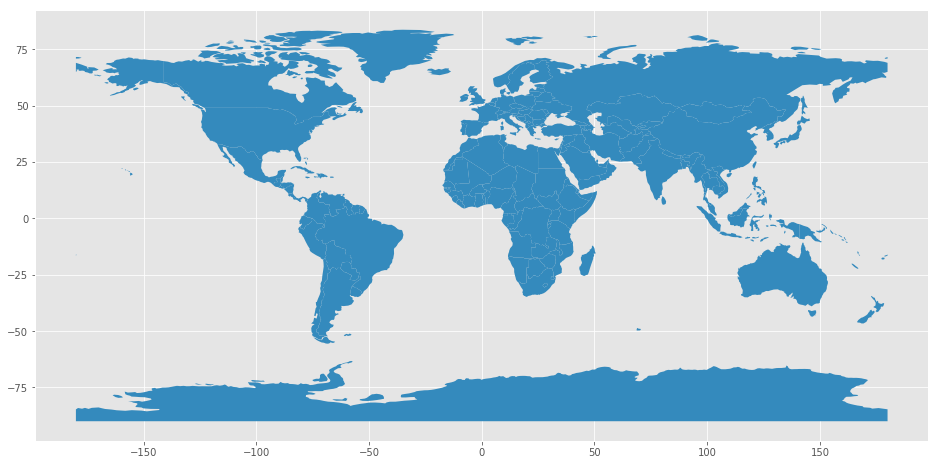

In [19]:
world.plot(figsize=(16,8))
plt.show()

## Task 5: Map plot overlays: Plotting multiple spatial layers

Here's a compact, quick way of Using GeoDataFrame plot method to overlay two GeoDataFrame. In this case we are overlaying the world and the Offshore Marine Zones.


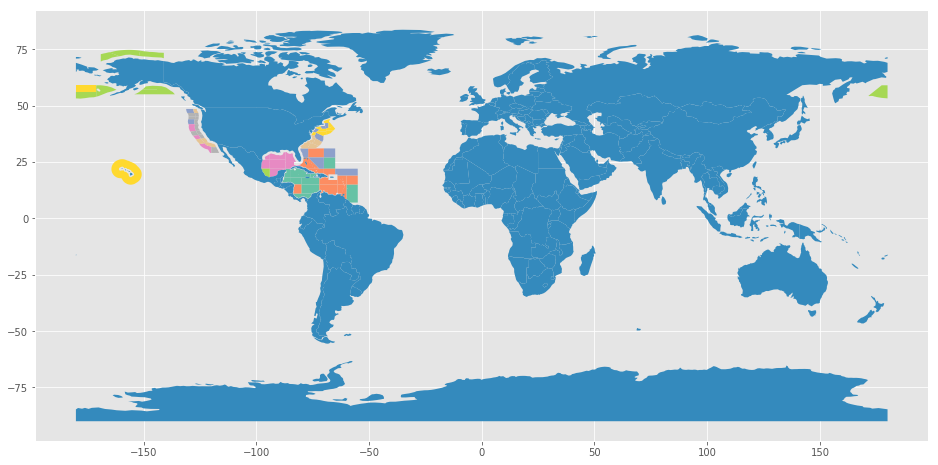

In [20]:
world.plot(ax=oz_df.plot(cmap='Set2', alpha=1, figsize=(16, 8)), alpha=1)
plt.show()

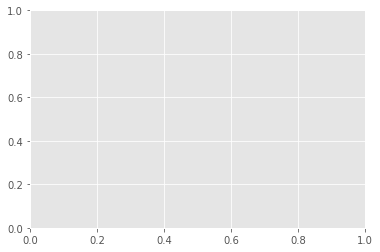

In [21]:
fig, ax = plt.subplots()

In [22]:
# set aspect to equal. This is done automatically
# when using *geopandas* plot on it's own, but not when
# working with pyplot directly.
ax.set_aspect('equal')

In [23]:
world.plot(ax=ax)
oz_df.plot(ax=ax)
hz_df.plot(ax=ax, color='red')
plt.show();

<Figure size 432x288 with 0 Axes>

## Task 6: Preparing Data for PySpark

The following cells will introduce some of the aggregation functions available to us in Spark SQL.

Spark expects a geospatial column as a WKT string. Internally it uses this to create OGC Geometries via Java Topology Suite (JTS). So in order to use Spatial Spark we will add the WKT column to our data.


In [24]:
world['wkt'] = pd.Series(
                map(lambda geom: str(geom.to_wkt()), world['geometry']),
                index=world.index, dtype='string')

In [25]:
oz_df['wkt'] = pd.Series(
                map(lambda geom: str(geom.to_wkt()), oz_df['geometry']),
                index=oz_df.index, dtype='string')
hz_df['wkt'] = pd.Series(
                map(lambda geom: str(geom.to_wkt()), hz_df['geometry']),
                index=hz_df.index, dtype='string')
mz_df['wkt'] = pd.Series(
                map(lambda geom: str(geom.to_wkt()), mz_df['geometry']),
                index=mz_df.index, dtype='string')

In [26]:
# drop the geometry column because Spark can't infer 
# a schema for it when it's a nested geometry shape
def drop_geometry_column(dataframe, col_drop="geometry"):
    return dataframe.drop(col_drop, axis=1)

## Task 7: Create a Spark dataframe from GeoPandas

In [27]:
world_spark_df = spark.createDataFrame(drop_geometry_column(world)).cache()

In [28]:
oz_spark_df = spark.createDataFrame(drop_geometry_column(oz_df)).cache()

In [29]:
mz_spark_df = spark.createDataFrame(mz_df).cache()

In [30]:
oz_spark_df.show()

+------+---+---------+--------+--------------------+--------------------+--------------------+
|    ID|WFO|      LON|     LAT|            LOCATION|                NAME|                 wkt|
+------+---+---------+--------+--------------------+--------------------+--------------------+
|AMZ031|NH2|-79.34953|11.83763|from 11N-15N betw...|Caribbean from 11...|POLYGON ((-72.006...|
|AMZ013|NH2| -81.7413|18.75795|north of 18N betw...|Caribbean N of 18...|POLYGON ((-82.344...|
|AMZ037|NH2|-59.99007|14.44086|from 7N-15N betwe...|Tropical N Atlant...|POLYGON ((-54.980...|
|AMZ121|NH2|-72.99113|24.81218|from 22N-27N betw...|Atlantic from 22N...|POLYGON ((-64.999...|
|AMZ011|NH2| -81.7413|18.75795|from 18N-22N west...|Caribbean Nof 18N...|POLYGON ((-85.003...|
|AMZ017|NH2| -81.7413|18.75795|south of 18N west...|    Gulf of Honduras|POLYGON ((-84.999...|
|AMZ019|NH2| -81.7413|18.75795|from 15N-18N betw...|Caribbean from 15...|POLYGON ((-80.001...|
|AMZ021|NH2| -81.7413|18.75795|from 15N-18N betw..

In [31]:
oz_spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- wkt: string (nullable = true)



In [32]:
oz_spark_df.select("LON","LAT").describe().show()

+-------+-----------------+----------------+
|summary|              LON|             LAT|
+-------+-----------------+----------------+
|  count|               80|              80|
|   mean|       -99.040287|    33.997170875|
| stddev|33.84410581917305|14.4896042862735|
|    min|          -184.25|        11.83763|
|    max|        -59.99007|          73.283|
+-------+-----------------+----------------+



In [33]:
mz_spark_df.show()

+------+---+------+--------------------+--------------+-------------+--------------------+--------------------+
|    ID|WFO|GL_WFO|                NAME|           LON|          LAT|            geometry|                 wkt|
+------+---+------+--------------------+--------------+-------------+--------------------+--------------------+
|PHZ113|HFO|  null|       Kauai Channel|-158.972419633|21.6169389324|[64344200, false, 2]|POLYGON ((-158.74...|
|PHZ112|HFO|  null|Kauai Leeward Waters|-160.231390339|21.6641220189|[59358520, false, 2]|POLYGON ((-159.62...|
|GMZ155|BRO|  null|Coastal waters fr...|-97.1579076835|26.9068452392|[64219880, false, 2]|POLYGON ((-96.882...|
|GMZ657|MFL|  null|Coastal waters fr...| -81.389491551| 25.453694266|[64332984, false, 2]|POLYGON ((-81.347...|
|GMZ656|MFL|  null|Coastal waters fr...| -81.872501149|25.9537191932|[65715448, false, 2]|MULTIPOLYGON (((-...|
|GMZ044|KEY|  null|Hawk Channel from...|-81.8740602707|24.5358389538|[64334200, false, 2]|POLYGON ((-81.

In [34]:
mz_spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- GL_WFO: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- __geom__: long (nullable = true)
 |    |-- _is_empty: boolean (nullable = true)
 |    |-- _ndim: long (nullable = true)
 |-- wkt: string (nullable = true)



In [35]:
mz_spark_df.select("LON","LAT").describe().show()

+-------+------------------+------------------+
|summary|               LON|               LAT|
+-------+------------------+------------------+
|  count|               500|               500|
|   mean|-90.59810613383728|38.696409805382835|
| stddev|  47.5954372849936|11.993500136917259|
|    min|    -175.184644413|    -14.3107175303|
|    max|     174.461825833|     71.6813223723|
+-------+------------------+------------------+



## Task 8: Get all countries from world_spark_df as Spark DataFrame

- Register a Temporary Table to allow us to call SQL-Like statements in Apache Spark against the points of Interests in SparkSQL DataFrame:



In [36]:
world_spark_df.createOrReplaceTempView("world")

In [37]:
# Select all countries
countries = spark.sql(
            """
            SELECT name, wkt as geometry, pop_est, continent
            FROM world
            ORDER BY continent, name
            """)

In [38]:
countries.show()

+--------------------+--------------------+-----------+---------+
|                name|            geometry|    pop_est|continent|
+--------------------+--------------------+-----------+---------+
|             Algeria|POLYGON ((11.9995...|3.4178188E7|   Africa|
|              Angola|MULTIPOLYGON (((1...|1.2799293E7|   Africa|
|               Benin|POLYGON ((2.69170...|  8791832.0|   Africa|
|            Botswana|POLYGON ((25.6491...|  1990876.0|   Africa|
|        Burkina Faso|POLYGON ((-2.8274...|1.5746232E7|   Africa|
|             Burundi|POLYGON ((29.3399...|  8988091.0|   Africa|
|            Cameroon|POLYGON ((13.0758...|1.8879301E7|   Africa|
|Central African Rep.|POLYGON ((15.2794...|  4511488.0|   Africa|
|                Chad|POLYGON ((14.4957...|1.0329208E7|   Africa|
|               Congo|POLYGON ((12.9955...|  4012809.0|   Africa|
|       Côte d'Ivoire|POLYGON ((-2.8561...|2.0617068E7|   Africa|
|     Dem. Rep. Congo|POLYGON ((30.8338...|6.8692542E7|   Africa|
|         

In [39]:
#count how many countries we have in our countries datasaet
countries.count()

177

## Task 10: Select a country from world dataframe and get its geographical boundary

### 1. Mexico

In [40]:
mexico = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Mexico'
    """)

In [41]:
mexico_boundary = wkt.loads(mexico.take(1)[0].wkt)

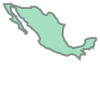

In [42]:
wkt.loads(mexico.take(1)[0].wkt)

### 2. Colombia

In [43]:
colombia = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Colombia'
    """)

In [44]:
colombia_boundary = wkt.loads(colombia.take(1)[0].wkt)

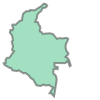

In [45]:
wkt.loads(colombia.take(1)[0].wk=cdegmvt)

### Venezuela

In [46]:
venezuela = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Venezuela'
    """)

In [47]:
venezuela_boundary = wkt.loads(venezuela.take(1)[0].wkt)

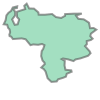

In [48]:
wkt.loads(venezuela.take(1)[0].wkt)

### Guyana

In [49]:
guyana = spark.sql(
    """
    SELECT wkt, name, pop_est, gdp_md_est
    FROM world
    WHERE name='Guyana'
    """)

In [50]:
guyana_boundary = wkt.loads(guyana.take(1)[0].wkt)

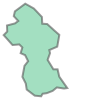

In [51]:
wkt.loads(guyana.take(1)[0].wkt)

## Task 11: Filter Offshore Marine Zones that intersect with Countries (Mexico, Colombia, Venezuela, Guyana) Boundaries

In [52]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf

In [53]:
# User defined funtion for filtering region of interset
intersection_udf_mexico = udf(lambda row: True if mexico_boundary.intersects(wkt.loads(row)) else False, BooleanType())

In [54]:
df_mexico = oz_spark_df.filter(intersection_udf_mexico(oz_spark_df["wkt"]))
pdf_mexico = df_mexico.toPandas() #convert to pandas datarframe
pdf_mexico

,ID,WFO,LON,LAT,LOCATION,NAME,wkt
0,AMZ011,NH2,-81.74130,18.75795,from 18N-22N west of 85W to Yucatan Peninsula ...,Caribbean Nof 18N W of 85W including Yucatan B...,POLYGON ((-85.0035124029999452 21.654186627000...
1,GMZ025,NH2,-93.95211,21.57751,south of 22N between 87W-94W,E Bay of Campeche including Campeche Bank,POLYGON ((-87.0053766059999703 22.014180185000...
2,GMZ017,NH2,-93.95211,21.57751,between 22N-26N west of 94W,W Central Gulf from 22N to 26N W of 94W,POLYGON ((-93.9921787359999712 26.006293284000...
3,GMZ023,NH2,-93.95211,21.57751,south of 22N west of 94W,SW Gulf S of 22N W of 94W,POLYGON ((-93.9995355959999870 22.011966694000...


In [55]:
geometry = pdf_mexico['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_mexico = gpd.GeoDataFrame(pdf_mexico, crs=crs, geometry=geometry)
gdf_mexico

,ID,WFO,LON,LAT,LOCATION,NAME,wkt,geometry
0,AMZ011,NH2,-81.74130,18.75795,from 18N-22N west of 85W to Yucatan Peninsula ...,Caribbean Nof 18N W of 85W including Yucatan B...,POLYGON ((-85.0035124029999452 21.654186627000...,POLYGON ((-85.00351240299995 21.65418662700006...
1,GMZ025,NH2,-93.95211,21.57751,south of 22N between 87W-94W,E Bay of Campeche including Campeche Bank,POLYGON ((-87.0053766059999703 22.014180185000...,POLYGON ((-87.00537660599997 22.01418018500004...
2,GMZ017,NH2,-93.95211,21.57751,between 22N-26N west of 94W,W Central Gulf from 22N to 26N W of 94W,POLYGON ((-93.9921787359999712 26.006293284000...,POLYGON ((-93.99217873599997 26.00629328400004...
3,GMZ023,NH2,-93.95211,21.57751,south of 22N west of 94W,SW Gulf S of 22N W of 94W,POLYGON ((-93.9995355959999870 22.011966694000...,POLYGON ((-93.99953559599999 22.01196669400002...


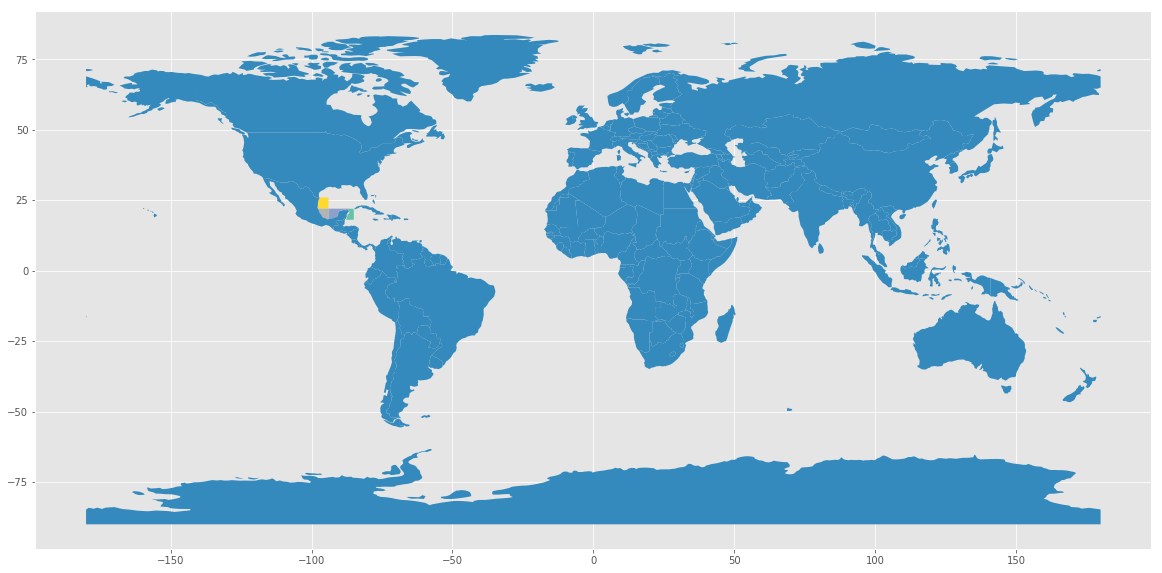

In [56]:
# Set the region of interest color to red
world.plot(ax=gdf_mexico.plot(cmap='Set2', alpha=1, color='green', figsize=(20, 10)), alpha=1)
plt.show()

In [81]:
gdf_mexico.describe()

,LON,LAT
count,4.000000,4.00000
mean,-90.899408,20.87262
std,6.105405,1.40978
min,-93.952110,18.75795
25%,-93.952110,20.87262
50%,-93.952110,21.57751
75%,-90.899407,21.57751
max,-81.741300,21.57751


### Colombia

In [57]:
intersection_udf_colombia = udf(lambda row: True if colombia_boundary.intersects(wkt.loads(row))
                       else False, BooleanType())

In [58]:
df_colombia = oz_spark_df.filter(intersection_udf_colombia(oz_spark_df["wkt"]))
pdf_colombia = df_colombia.toPandas() #convert to pandas dataframe
pdf_colombia

,ID,WFO,LON,LAT,LOCATION,NAME,wkt
0,AMZ039,NH2,-79.34953,11.83763,south of 11N between Colombia and Costa Rica,SW Caribbean S of 11N including the approaches...,POLYGON ((-80.0132461609999837 10.989629904000...


In [59]:
geometry = pdf_colombia['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_colombia = gpd.GeoDataFrame(pdf_colombia, crs=crs, geometry=geometry)
gdf_colombia

,ID,WFO,LON,LAT,LOCATION,NAME,wkt,geometry
0,AMZ039,NH2,-79.34953,11.83763,south of 11N between Colombia and Costa Rica,SW Caribbean S of 11N including the approaches...,POLYGON ((-80.0132461609999837 10.989629904000...,POLYGON ((-80.01324616099998 10.98962990400003...


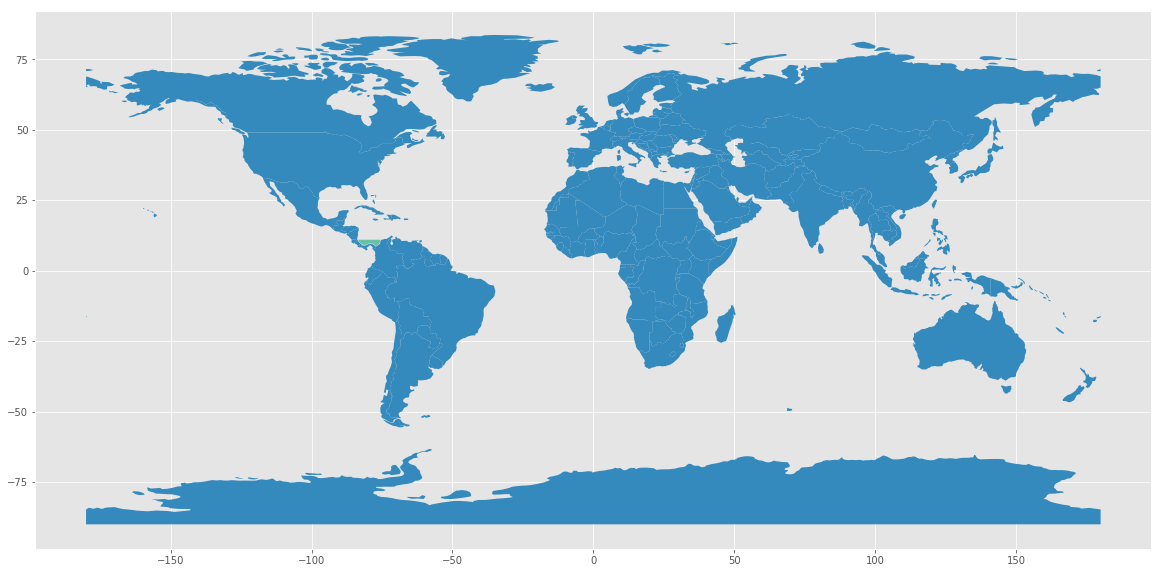

In [60]:
world.plot(ax=gdf_colombia.plot(cmap='Set2',alpha=1, color='red', figsize=(20, 10)), alpha=1)
plt.show()

In [82]:
gdf_colombia.describe()

,LON,LAT
count,1.00000,1.00000
mean,-79.34953,11.83763
std,NaN,NaN
min,-79.34953,11.83763
25%,-79.34953,11.83763
50%,-79.34953,11.83763
75%,-79.34953,11.83763
max,-79.34953,11.83763


### Venezuela

In [61]:
# User defined funtion for filtering region of interset
intersection_udf_venezuela = udf(lambda row: True if venezuela_boundary.intersects(wkt.loads(row)) else False, BooleanType())

In [62]:
df_venezuela = oz_spark_df.filter(intersection_udf_venezuela(oz_spark_df["wkt"]))
pdf_venezuela = df_venezuela.toPandas()
pdf_venezuela

,ID,WFO,LON,LAT,LOCATION,NAME,wkt
0,AMZ037,NH2,-59.99007,14.44086,from 7N-15N between 55W-60W,Tropical N Atlantic from 7N and 15N between 55...,POLYGON ((-54.9801489519999791 15.002949367000...
1,AMZ035,NH2,-59.99007,14.44086,south of 15N between 60W-64W,Offshore Waters Windward Islands including Tri...,POLYGON ((-64.0074824779999858 15.031426411000...
2,AMZ033,NH2,-68.13905,15.13334,south of 15N between 64W-72W,Caribbean S of 15N between 64W and 72W includi...,MULTIPOLYGON (((-64.0074824779999858 15.031426...


In [63]:
geometry = pdf_venezuela['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_venezuela = gpd.GeoDataFrame(pdf_venezuela, crs=crs, geometry=geometry)
gdf_venezuela

,ID,WFO,LON,LAT,LOCATION,NAME,wkt,geometry
0,AMZ037,NH2,-59.99007,14.44086,from 7N-15N between 55W-60W,Tropical N Atlantic from 7N and 15N between 55...,POLYGON ((-54.9801489519999791 15.002949367000...,POLYGON ((-54.98014895199998 15.00294936700004...
1,AMZ035,NH2,-59.99007,14.44086,south of 15N between 60W-64W,Offshore Waters Windward Islands including Tri...,POLYGON ((-64.0074824779999858 15.031426411000...,POLYGON ((-64.00748247799999 15.03142641100004...
2,AMZ033,NH2,-68.13905,15.13334,south of 15N between 64W-72W,Caribbean S of 15N between 64W and 72W includi...,MULTIPOLYGON (((-64.0074824779999858 15.031426...,(POLYGON ((-64.00748247799999 15.0314264110000...


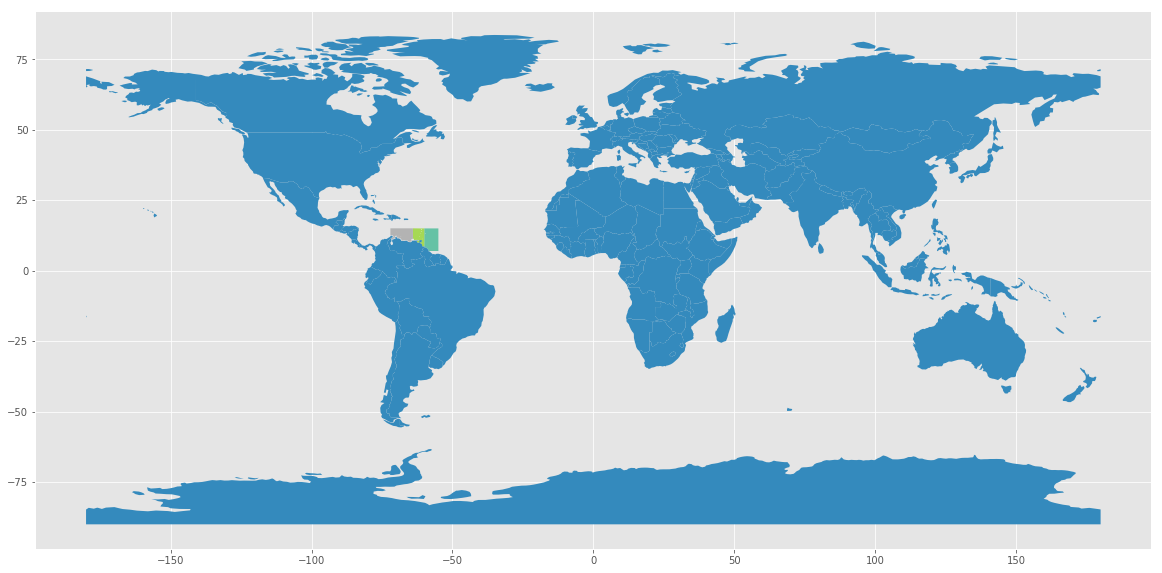

In [64]:
# Set the region of interest color to red
world.plot(ax=gdf_venezuela.plot(cmap='Set2', alpha=1, color='red', figsize=(20, 10)), alpha=1)
plt.show()

In [83]:
gdf_venezuela.describe()

,LON,LAT
count,3.000000,3.000000
mean,-62.706397,14.671687
std,4.704816,0.399804
min,-68.139050,14.440860
25%,-64.064560,14.440860
50%,-59.990070,14.440860
75%,-59.990070,14.787100
max,-59.990070,15.133340


### Guyana

In [65]:
intersection_udf_guyana = udf(lambda row: True if guyana_boundary.intersects(wkt.loads(row))
                              else False, BooleanType())

In [66]:
df_guyana = oz_spark_df.filter(intersection_udf_guyana(oz_spark_df["wkt"]))
pdf_guyana = df_guyana.toPandas()
pdf_guyana

,ID,WFO,LON,LAT,LOCATION,NAME,wkt
0,AMZ037,NH2,-59.99007,14.44086,from 7N-15N between 55W-60W,Tropical N Atlantic from 7N and 15N between 55...,POLYGON ((-54.9801489519999791 15.002949367000...


In [67]:
geometry = pdf_guyana['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf_guyana = gpd.GeoDataFrame(pdf_guyana, crs=crs, geometry=geometry)
gdf_guyana

,ID,WFO,LON,LAT,LOCATION,NAME,wkt,geometry
0,AMZ037,NH2,-59.99007,14.44086,from 7N-15N between 55W-60W,Tropical N Atlantic from 7N and 15N between 55...,POLYGON ((-54.9801489519999791 15.002949367000...,POLYGON ((-54.98014895199998 15.00294936700004...


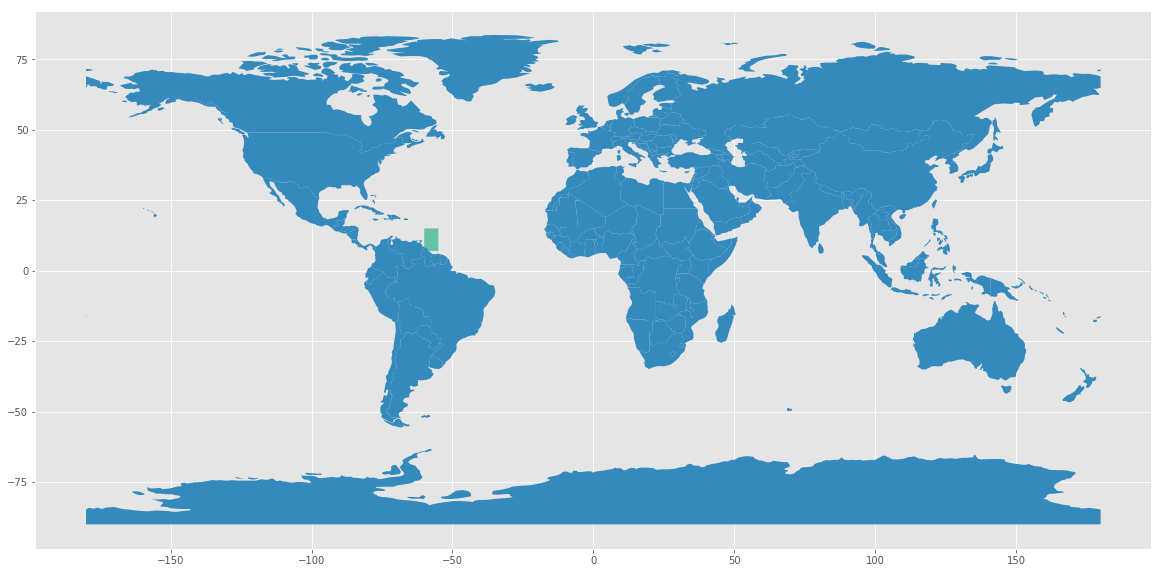

In [68]:
# Set the region of interest color to red
world.plot(ax=gdf_guyana.plot(cmap='Set2', alpha=1, color='red',figsize=(20, 10)), alpha=1)
plt.show()

In [84]:
gdf_guyana.describe()

,LON,LAT
count,1.00000,1.00000
mean,-59.99007,14.44086
std,NaN,NaN
min,-59.99007,14.44086
25%,-59.99007,14.44086
50%,-59.99007,14.44086
75%,-59.99007,14.44086
max,-59.99007,14.44086


## Task 12: Select Boundaries for Weather Forecast Office (WFO) Honolulu (HFO)

In [69]:
oz_spark_df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- WFO: string (nullable = true)
 |-- LON: double (nullable = true)
 |-- LAT: double (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- wkt: string (nullable = true)



In [70]:
oz_spark_df.show()

+------+---+---------+--------+--------------------+--------------------+--------------------+
|    ID|WFO|      LON|     LAT|            LOCATION|                NAME|                 wkt|
+------+---+---------+--------+--------------------+--------------------+--------------------+
|AMZ031|NH2|-79.34953|11.83763|from 11N-15N betw...|Caribbean from 11...|POLYGON ((-72.006...|
|AMZ013|NH2| -81.7413|18.75795|north of 18N betw...|Caribbean N of 18...|POLYGON ((-82.344...|
|AMZ037|NH2|-59.99007|14.44086|from 7N-15N betwe...|Tropical N Atlant...|POLYGON ((-54.980...|
|AMZ121|NH2|-72.99113|24.81218|from 22N-27N betw...|Atlantic from 22N...|POLYGON ((-64.999...|
|AMZ011|NH2| -81.7413|18.75795|from 18N-22N west...|Caribbean Nof 18N...|POLYGON ((-85.003...|
|AMZ017|NH2| -81.7413|18.75795|south of 18N west...|    Gulf of Honduras|POLYGON ((-84.999...|
|AMZ019|NH2| -81.7413|18.75795|from 15N-18N betw...|Caribbean from 15...|POLYGON ((-80.001...|
|AMZ021|NH2| -81.7413|18.75795|from 15N-18N betw..

In [71]:
oz_spark_df.groupBy("WFO").count().show()

+---+-----+
|WFO|count|
+---+-----+
|NH2|   32|
|ONP|   19|
|AFC|    6|
|AFG|    3|
|HPA|    1|
|ONA|   18|
|AJK|    1|
+---+-----+



In [72]:
oz_spark_df.createOrReplaceTempView("offshore")

In [73]:
hfo = spark.sql("""
        SELECT wkt
        FROM offshore
        WHERE WFO='HPA'
        """)

In [74]:
hfo.show()

+--------------------+
|                 wkt|
+--------------------+
|POLYGON ((-159.40...|
+--------------------+



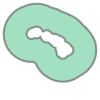

In [75]:
hfo_boundaries = wkt.loads(hfo.take(1)[0].wkt)
hfo_boundaries

In [76]:
# User defined funtion for filtering region of interset
within_udf = udf(lambda row: True if hfo_boundaries.within(wkt.loads(row)) else False, BooleanType())


In [77]:
df = oz_spark_df.filter(within_udf(oz_spark_df["wkt"]))
pdf = df.toPandas()
pdf

,ID,WFO,LON,LAT,LOCATION,NAME,wkt
0,PHZ180,HPA,-160.87879,20.57628,None,Hawaiian Offshore Waters,POLYGON ((-159.4000661719999812 26.23540199700...


In [78]:
geometry = pdf['wkt'].map(wkt.loads)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(pdf, crs=crs, geometry=geometry)

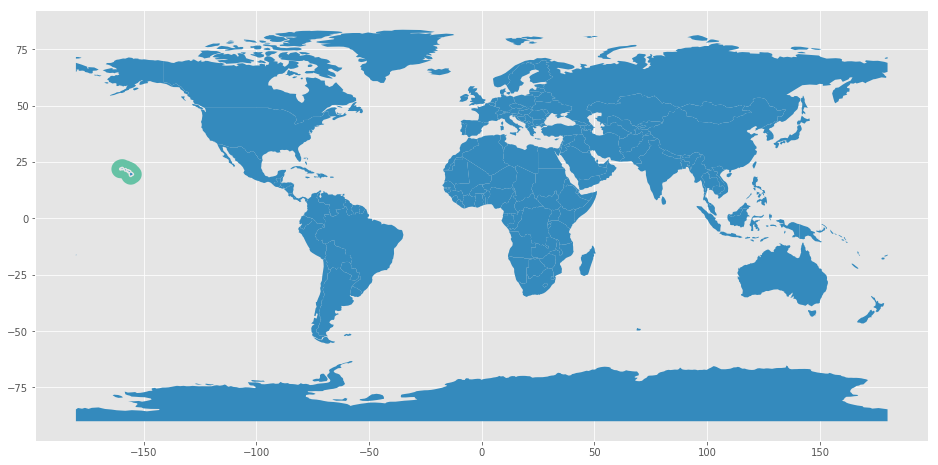

In [80]:
world.plot(ax=gdf.plot(cmap='Set2', alpha=1, color='red', figsize=(16, 8)), alpha=1)
plt.show()